# STDP applied to a synaptic layer
** Demonstrates how to apply the STDP learning rule **

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

from spikeflow import firing_to_spike_process, firings_to_spike_processes
from spikeflow import spike_process_delta_times
from spikeflow import STDPParams, STDP_Tracer, STDPLearningRule, WeightBounds
from spikeflow import IdentityNeuronLayer, Synapse, ComplexSynapseLayer, weights_from_synapses
from spikeflow import BPNNModel
from spikeflow.drawing_utils.trace_renderers import STDPTracesRenderer, IdentityNeuronTraceRenderer, render_figure

/Applications/Anaconda/anaconda/envs/mlbook/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Some utils

In [3]:
def inp_fir(pre, dur, pos):
    return [0] * pre + [1] * dur + [0] * pos

def inp_firs(n, pre, dur, pos):
    return np.array([ inp_fir(pre, dur, pos) for _ in range(n) ]).T

def data_generator(n, spikes=1):
    iv = inp_firs(n, 40, spikes, 50-spikes)
    for f in iv:
        yield np.array(f)
        
def get_model(num_input_neurons, num_output_neurons, use_teaching_inputs=False):
    input_neuron_layer = IdentityNeuronLayer('input_neuron_layer', num_input_neurons)

    output_neuron_layer = IdentityNeuronLayer('output_neuron_layer', num_output_neurons)

    forward_connection = ComplexSynapseLayer('fsyn',
        input_neuron_layer, 
        output_neuron_layer, 
        decay = 0.0,
        weights = weights_from_synapses(input_neuron_layer, output_neuron_layer, [
            Synapse(0, 0, 0.5),
            Synapse(1, 0, 0.5),
            Synapse(0, 1, 0.5),
            Synapse(1, 1, 0.5),
            Synapse(0, 2, 0.5),
            Synapse(1, 2, 0.5)
        ])
    )

    learning_rule = STDPLearningRule(
        name = 'stdp_on_forward_connection',
        connection_layer = forward_connection,
        stdp_params = STDPParams(APlus=1.0, AMinus=2.0, TauPlus=1.4, TauMinus=1.7, all_to_all=True), 
        weight_bounds = WeightBounds(WMax=1.5, EtaPlus=0.4, EtaMinus=0.3, Soft=True),
        uses_teaching_signal = use_teaching_inputs)

    model = BPNNModel.compiled_model((num_input_neurons,), 
                                     [input_neuron_layer, output_neuron_layer], 
                                     [forward_connection],
                                     [learning_rule])
    
    return model, forward_connection, learning_rule

def render_traces(traces):
    input_neuron_traces = np.array([r['input_neuron_layer'] for r in traces])
    output_neuron_traces = np.array([r['output_neuron_layer'] for r in traces])

    render_figure(
        [IdentityNeuronTraceRenderer(input_neuron_traces, 'Input Neurons'),
         IdentityNeuronTraceRenderer(output_neuron_traces, 'Output Neurons')
        ], 
        0, 
        len(traces))

In [4]:
ni = 2
no = 3
model_input_shape = (ni,)

# Feed input through a model, but don't learn

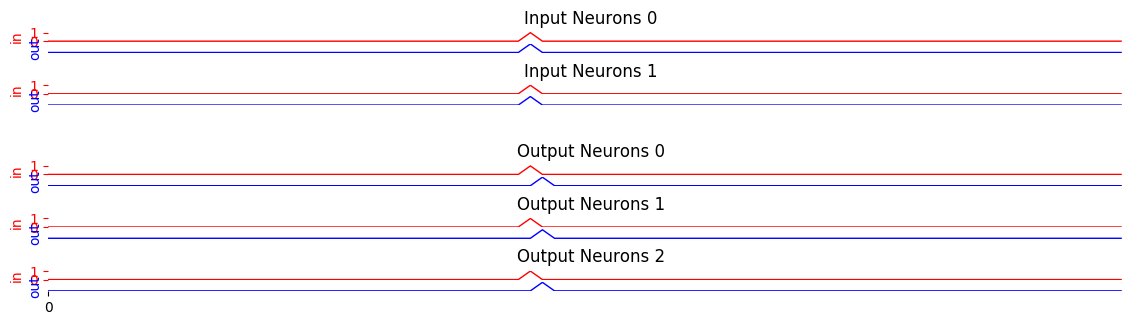

In [5]:
# --- Create the model ---

model, _, _ = get_model(ni, no)
print(model)


# --- run the model ---

traces = []

def end_time_step_callback(i, graph, sess, results):
    traces.append(results)
    
model.run_time(data_generator(ni), end_time_step_callback)


# --- render results ---

render_traces(traces)

# Feed input through a model, trigger learning on the final step

INITIAL W
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]]
FINAL W
[[0.9 0.9 0.9]
 [0.9 0.9 0.9]]


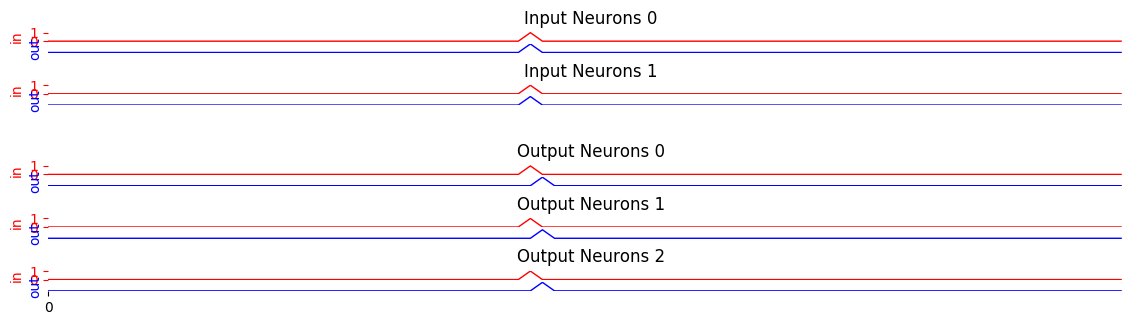

In [6]:
# --- Create the model ---

model, forward_connection, _ = get_model(ni, no)

print(model)
print('INITIAL W')
print(forward_connection.w)


# --- run the model ---

traces = []

def end_time_step_callback(i, graph, sess, results):
    traces.append(results)
    if i == 89:
        
        # TRIGGER LEARNING AT THE END!!!
        learning_results = model.learn(sess)
        final_W = learning_results['stdp_on_forward_connection'][0]
        
        print('FINAL W')
        print(final_W)        
    
model.run_time(data_generator(ni), end_time_step_callback)

    
# --- render results ---

render_traces(traces)

# Same with more firings

INITIAL W
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]]
FINAL W
[[1.5 1.5 1.5]
 [1.5 1.5 1.5]]


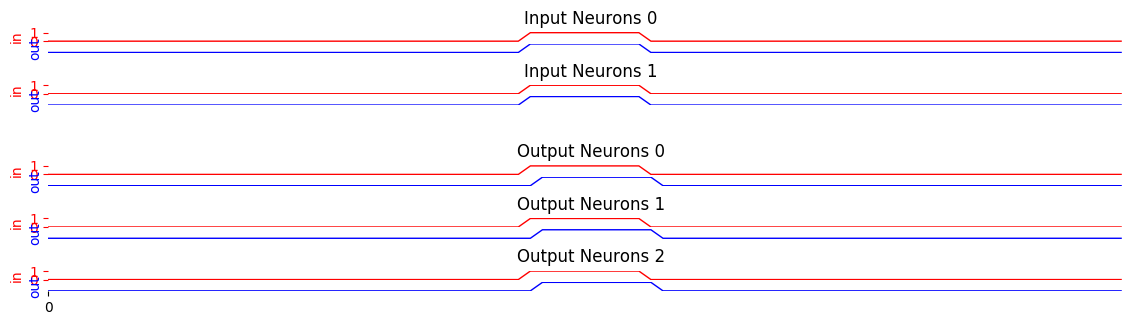

In [7]:
# --- Create the model ---

model, forward_connection, _ = get_model(ni, no)

print(model)
print('INITIAL W')
print(forward_connection.w)


# --- run the model ---

traces = []

def end_time_step_callback(i, graph, sess, results):
    traces.append(results)
    if i == 89:
        
        # TRIGGER LEARNING AT THE END!!!
        learning_results = model.learn(sess)
        final_W = learning_results['stdp_on_forward_connection'][0]
        
        print('FINAL W')
        print(final_W)        
    
model.run_time(data_generator(ni, spikes=10), end_time_step_callback)

    
# --- render results ---

render_traces(traces)

# Same, but use teaching input to suppress learning ('teaching input = 0')

INITIAL W
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]]
FINAL W
[[0.37661594 0.37661594 0.37661594]
 [0.37661594 0.37661594 0.37661594]]


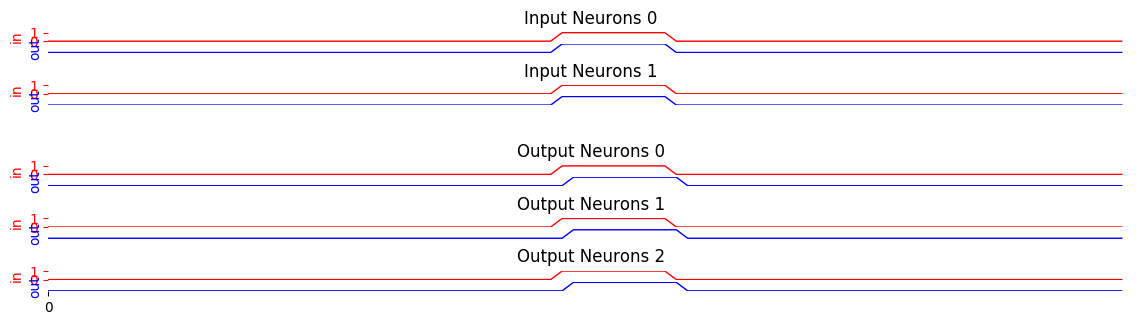

In [8]:
# --- Create the model ---

model, forward_connection, learning_rule = get_model(ni, no, use_teaching_inputs=True)

print(model)
print('INITIAL W')
print(forward_connection.w)


# --- define a data generator that generates inputs as well as teaching signals

def data_and_teaching_input_generator(num_input, num_output):
    input_inputs = inp_firs(num_input, 45, 10, 45)
    teaching_inputs = np.array([ ([0]*30 + [1]*10 + [0]*55) for _ in range(num_output)]).T
    for input_input, teaching_input in zip(input_inputs, teaching_inputs):
        yield { model.input: input_input, learning_rule.teaching_signal: teaching_input }

        
# --- run the model ---

traces = []

def end_time_step_callback(i, graph, sess, results):
    traces.append(results)
    # hey, just for kicks, turn it off if you want...
    #if i == 0: learning_rule.set_uses_teaching_signal(False, sess)
    if i == 89:
        final_W = model.learn(sess)
        print('FINAL W')
        print(final_W['stdp_on_forward_connection'][0])        
    
model.run_time(data_and_teaching_input_generator(ni, no), end_time_step_callback)


# --- render results ---

render_traces(traces)